# Models Testing  


This section will attempt to identify the best classification model for the two classes.  

Five different classification models will be trained on the data which includes MultinomialNaiveBayes(NB), LogisticRegression(LR), kNearestNeighbors(kNN), SupportVectorMachine(SVM), and RandomForestClassifer(RF).  

Each of these models will also be paired first with CountVectorizer and TF-IDF Vectorizer to tokenize and make a count of the most important word tokens.  

The best model will then be selected based on the best 'Accuracy Score'. 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re

from wordcloud import WordCloud

from bs4 import BeautifulSoup

import seaborn as sns

In [3]:
df = pd.read_csv('./datasets/cleaned_reddit_posts.csv')[['subreddit_label', 'clean_text']]

# Drop rows with non-ASCII text
df.dropna(inplace=True)
df.isnull().sum()

# Drop duplicate rows
df.drop_duplicates(inplace=True)
df.shape

(18798, 2)

In [4]:
X = df['clean_text']
y = df['subreddit_label']

# Baseline accuracy score
y.value_counts(normalize=True)

1    0.519257
0    0.480743
Name: subreddit_label, dtype: float64

_51% of the dataset are from r\askSingapore while 48% are from r\Singapore._

In [5]:
# From "EDA on Titles+Selftext", we can remove these additional stopwords as they are more likely to be noise than signals

new_stopwords = ['singapor',
 'free',
 'hdb',
 'www',
 'top',
 'care',
 'small',
 'gener',
 'bto',
 'world',
 'ce',
 'public',
 'clean',
 'woman',
 'provid',
 'support',
 'unit',
 'flat',
 'scam',
 'china',
 'water',
 'polic',
 'increas',
 'road',
 'charg',
 'system',
 'claim',
 'worker',
 'detail',
 'data',
 'event',
 'covid',
 'ticket',
 'th',
 'fix',
 'govern',
 'driver',
 'activ',
 'singtel',
 'news',
 'line',
 'nation',
 'collect',
 'import',
 'remov',
 'christma',
 'sale',
 'medium',
 'station',
 'die',
 'link',
 'owner',
 'condo',
 'perform',
 'centr',
 'profession',
 'bill',
 'indian',
 'invest',
 'changi',
 'staff',
 'east',
 'site',
 'chat',
 'court',
 'dec',
 'rais',
 'real',
 'hawker',
 'cat',
 'sourc',
 'land',
 'resid',
 'parti',
 'condit',
 'cup',
 'art',
 'ride',
 'space',
 'ad',
 'decemb',
 'st',
 'mobil',
 'dog',
 'board',
 'street',
 'develop',
 'sport',
 'benefit',
 'march',
 'risk',
 'nu',
 'movi',
 'step',
 'natur',
 'tv',
 'paper',
 'west',
 'refund',
 'power',
 'lead',
 'beauti',
 'marriag',
 'appoint',
 'taxi',
 'box',
 'employe',
 'mask',
 'voucher',
 'rice',
 'queue']

## Model 1: CountVectorizer & NaiveBayes

In [233]:
# Gridsearch with CountVectorizer and NaiveBayes

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words=new_stopwords)),   # remove additional stopwords
    ('nb', MultinomialNB())
])

pipe.get_params()

{'memory': None,
 'steps': [('cvec',
   CountVectorizer(stop_words=['singapor', 'free', 'hdb', 'www', 'top', 'care',
                               'small', 'gener', 'bto', 'world', 'ce', 'public',
                               'clean', 'woman', 'provid', 'support', 'unit',
                               'flat', 'scam', 'china', 'water', 'polic',
                               'increas', 'road', 'charg', 'system', 'claim',
                               'worker', 'detail', 'data', ...])),
  ('nb', MultinomialNB())],
 'verbose': False,
 'cvec': CountVectorizer(stop_words=['singapor', 'free', 'hdb', 'www', 'top', 'care',
                             'small', 'gener', 'bto', 'world', 'ce', 'public',
                             'clean', 'woman', 'provid', 'support', 'unit',
                             'flat', 'scam', 'china', 'water', 'polic',
                             'increas', 'road', 'charg', 'system', 'claim',
                             'worker', 'detail', 'data', ...]),
 'nb'

In [234]:
# Search over following hyperparams

pipe_cvec_params = {
    'cvec__max_features': [3000],
    'cvec__ngram_range': [(1,1), (1,2), (1,3)]
}



In [235]:
# Instantiate GridSearchCV

cvec_nb = GridSearchCV(pipe,
                 pipe_cvec_params,
                 cv=5)

In [236]:
# Fit and score best model
cvec_nb.fit(X_train, y_train)


# Check Accuracy score 
print(f"Training score: {cvec_nb.score(X_train, y_train)}")
print(f"Testing score: {cvec_nb.score(X_test, y_test)}")

Training score: 0.7425876010781671
Testing score: 0.7061702127659575


In [237]:
# Check best_estimator hyperparameters
cvec_nb.best_params_

{'cvec__max_features': 3000, 'cvec__ngram_range': (1, 3)}

In [238]:
cvec_nb.best_estimator_[-1].n_features_in_

3000

## Model 2: TF-IDF Vectorizer & NaiveBayes

In [245]:
# Gridsearch with TF-IDF Vectorizer and NaiveBayes

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

pipe = Pipeline([
    ('tvec', TfidfVectorizer(stop_words=new_stopwords)),   # remove additional stopwords
    ('nb', MultinomialNB())
])


pipe.get_params()

{'memory': None,
 'steps': [('tvec',
   TfidfVectorizer(stop_words=['singapor', 'free', 'hdb', 'www', 'top', 'care',
                               'small', 'gener', 'bto', 'world', 'ce', 'public',
                               'clean', 'woman', 'provid', 'support', 'unit',
                               'flat', 'scam', 'china', 'water', 'polic',
                               'increas', 'road', 'charg', 'system', 'claim',
                               'worker', 'detail', 'data', ...])),
  ('nb', MultinomialNB())],
 'verbose': False,
 'tvec': TfidfVectorizer(stop_words=['singapor', 'free', 'hdb', 'www', 'top', 'care',
                             'small', 'gener', 'bto', 'world', 'ce', 'public',
                             'clean', 'woman', 'provid', 'support', 'unit',
                             'flat', 'scam', 'china', 'water', 'polic',
                             'increas', 'road', 'charg', 'system', 'claim',
                             'worker', 'detail', 'data', ...]),
 'nb'

In [246]:
# Search over following hyperparams
pipe_tvec_params = {
    'tvec__max_features': [2_000, 3000],
    'tvec__ngram_range': [(1,1), (1,2), (1,3)]
}

In [247]:
# Instantiate GridSearchCV
tvec_nb = GridSearchCV(pipe,
                      pipe_tvec_params,
                      cv=5)

In [248]:
# Fit and score best model
tvec_nb.fit(X_train, y_train)


# Check Accuracy score 
print(f"Training score: {tvec_nb.score(X_train, y_train)}")
print(f"Testing score: {tvec_nb.score(X_test, y_test)}")

Training score: 0.7652858561498085
Testing score: 0.7157446808510638


In [249]:
tvec_nb.best_params_

{'tvec__max_features': 3000, 'tvec__ngram_range': (1, 2)}

When estimating using NaiveBayes model, using TfidfVectorizer instead of CountVectorizer performed better both in-sample and out-of-sample

## Model 3: CountVectorizer & LogisticRegression

In [154]:
# LogisticRegression modeling

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

cvec_lr = Pipeline([
    ('cvec', CountVectorizer(stop_words=new_stopwords, max_features=4000)),
    ('ss', StandardScaler(with_mean=False)),
    ('lr', LogisticRegression(C=0.000005, solver='lbfgs'))
])


cvec_lr.get_params()

{'memory': None,
 'steps': [('cvec', CountVectorizer(max_features=4000,
                   stop_words=['singapor', 'free', 'hdb', 'www', 'top', 'care',
                               'small', 'gener', 'bto', 'world', 'ce', 'public',
                               'clean', 'woman', 'provid', 'support', 'unit',
                               'flat', 'scam', 'china', 'water', 'polic',
                               'increas', 'road', 'charg', 'system', 'claim',
                               'worker', 'detail', 'data', ...])),
  ('ss', StandardScaler(with_mean=False)),
  ('lr', LogisticRegression(C=5e-06))],
 'verbose': False,
 'cvec': CountVectorizer(max_features=4000,
                 stop_words=['singapor', 'free', 'hdb', 'www', 'top', 'care',
                             'small', 'gener', 'bto', 'world', 'ce', 'public',
                             'clean', 'woman', 'provid', 'support', 'unit',
                             'flat', 'scam', 'china', 'water', 'polic',
                   

In [155]:
# Fit and score best model
cvec_lr.fit(X_train, y_train)

print(f"Training score: {cvec_lr.score(X_train, y_train)}")
print(f"Testing score: {cvec_lr.score(X_test, y_test)}")

Training score: 0.8156476095900128
Testing score: 0.8014893617021277


In [156]:
# Get number of features used in model
cvec_lr[-1].n_features_in_

4000

## Model 4: TF-IDF Vectorizer & LogisticRegression

In [171]:
# LogisticRegression modeling

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

tvec_lr = Pipeline([
    ('tvec', TfidfVectorizer(stop_words=new_stopwords, max_features=3000)),
    ('ss', StandardScaler(with_mean=False)),
    ('lr', LogisticRegression(C=0.00001, solver='lbfgs'))
])


tvec_lr.get_params()

{'memory': None,
 'steps': [('tvec', TfidfVectorizer(max_features=3000,
                   stop_words=['singapor', 'free', 'hdb', 'www', 'top', 'care',
                               'small', 'gener', 'bto', 'world', 'ce', 'public',
                               'clean', 'woman', 'provid', 'support', 'unit',
                               'flat', 'scam', 'china', 'water', 'polic',
                               'increas', 'road', 'charg', 'system', 'claim',
                               'worker', 'detail', 'data', ...])),
  ('ss', StandardScaler(with_mean=False)),
  ('lr', LogisticRegression(C=1e-05))],
 'verbose': False,
 'tvec': TfidfVectorizer(max_features=3000,
                 stop_words=['singapor', 'free', 'hdb', 'www', 'top', 'care',
                             'small', 'gener', 'bto', 'world', 'ce', 'public',
                             'clean', 'woman', 'provid', 'support', 'unit',
                             'flat', 'scam', 'china', 'water', 'polic',
                   

In [172]:
# Fit and score best model

tvec_lr.fit(X_train, y_train)

print(f"Training score: {tvec_lr.score(X_train, y_train)}")
print(f"Testing score: {tvec_lr.score(X_test, y_test)}")

Training score: 0.8017449283586324
Testing score: 0.7606382978723404


When using LogisticRegression to classify, both CountVectorizer and TfidfVectorizer performed relatively similar.

In [173]:
# Get number of features used in model
tvec_lr[-1].n_features_in_

3000

## Model 5: CountVectorizer & k-NearestNeighbors

In [154]:
# Try GridSearch with kNN

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words=new_stopwords)),
    ('knn', KNeighborsClassifier())
     ])


pipe.get_params()

{'memory': None,
 'steps': [('cvec',
   CountVectorizer(stop_words=['singapor', 'free', 'hdb', 'www', 'top', 'care',
                               'small', 'gener', 'bto', 'world', 'ce', 'public',
                               'clean', 'woman', 'provid', 'support', 'unit',
                               'flat', 'scam', 'china', 'water', 'polic',
                               'increas', 'road', 'charg', 'system', 'claim',
                               'worker', 'detail', 'data', ...])),
  ('knn', KNeighborsClassifier())],
 'verbose': False,
 'cvec': CountVectorizer(stop_words=['singapor', 'free', 'hdb', 'www', 'top', 'care',
                             'small', 'gener', 'bto', 'world', 'ce', 'public',
                             'clean', 'woman', 'provid', 'support', 'unit',
                             'flat', 'scam', 'china', 'water', 'polic',
                             'increas', 'road', 'charg', 'system', 'claim',
                             'worker', 'detail', 'data', ...]

In [155]:
pipe_cvec_params = {
    'cvec__max_features': [100, 300, 500],
    'cvec__ngram_range': [(1,1), (1,2), (1,3)],
    'knn__n_neighbors': [5]  
}

In [156]:
# Instantiate GridSearchCV
cvec_knn = GridSearchCV(pipe,
                      pipe_cvec_params,
                      cv=5)

In [157]:
# Fit and score best model
cvec_knn.fit(X_train, y_train)


# Check Accuracy score 
print(f"Training score: {cvec_knn.score(X_train, y_train)}")
print(f"Testing score: {cvec_knn.score(X_test, y_test)}")

Training score: 0.759682224428997
Testing score: 0.6793617021276596


In [158]:
cvec_knn.best_params_

{'cvec__max_features': 100, 'cvec__ngram_range': (1, 1), 'knn__n_neighbors': 5}

In [161]:
cvec_knn.best_estimator_[-1].n_features_in_

100

## Model 6: TF-IDF Vectorizer & k-NearestNeighbors

In [178]:
# Try GridSearch with kNN

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

pipe = Pipeline([
    ('tvec', TfidfVectorizer(stop_words=new_stopwords)),
    ('knn', KNeighborsClassifier())
     ])


pipe.get_params()

{'memory': None,
 'steps': [('tvec',
   TfidfVectorizer(stop_words=['singapor', 'free', 'hdb', 'www', 'top', 'care',
                               'small', 'gener', 'bto', 'world', 'ce', 'public',
                               'clean', 'woman', 'provid', 'support', 'unit',
                               'flat', 'scam', 'china', 'water', 'polic',
                               'increas', 'road', 'charg', 'system', 'claim',
                               'worker', 'detail', 'data', ...])),
  ('knn', KNeighborsClassifier())],
 'verbose': False,
 'tvec': TfidfVectorizer(stop_words=['singapor', 'free', 'hdb', 'www', 'top', 'care',
                             'small', 'gener', 'bto', 'world', 'ce', 'public',
                             'clean', 'woman', 'provid', 'support', 'unit',
                             'flat', 'scam', 'china', 'water', 'polic',
                             'increas', 'road', 'charg', 'system', 'claim',
                             'worker', 'detail', 'data', ...]

In [179]:
pipe_tvec_params = {
    'tvec__max_features': [100, 300, 500],
    'tvec__ngram_range': [(1,1)],
    'knn__n_neighbors': [5]  
}

In [180]:
# Instantiate GridSearchCV
tvec_knn = GridSearchCV(pipe,
                      pipe_tvec_params,
                      cv=5)

In [181]:
# Fit and score best model
tvec_knn.fit(X_train, y_train)


# Check Accuracy score 
print(f"Training score: {tvec_knn.score(X_train, y_train)}")
print(f"Testing score: {tvec_knn.score(X_test, y_test)}")

Training score: 0.7423038728897716
Testing score: 0.6593617021276595


In [256]:
tvec_knn.best_params_

{'knn__n_neighbors': 5, 'tvec__max_features': 100, 'tvec__ngram_range': (1, 1)}

In [261]:
tvec_knn.best_estimator_[0].get_feature_names_out()

array(['advic', 'also', 'anyon', 'around', 'ask', 'back', 'best', 'buy',
       'call', 'come', 'compani', 'could', 'current', 'date', 'day',
       'end', 'etc', 'even', 'experi', 'famili', 'feel', 'find', 'first',
       'food', 'friend', 'get', 'give', 'go', 'good', 'got', 'guy',
       'help', 'hi', 'home', 'http', 'im', 'issu', 'job', 'know', 'life',
       'like', 'live', 'long', 'look', 'lot', 'make', 'mani', 'money',
       'month', 'move', 'much', 'need', 'new', 'one', 'parent', 'part',
       'pay', 'peopl', 'person', 'place', 'plan', 'plea', 'price',
       'question', 'quit', 'realli', 'recent', 'recommend', 'said', 'say',
       'school', 'see', 'seem', 'servic', 'sg', 'share', 'sinc',
       'singaporean', 'someon', 'someth', 'start', 'still', 'sure',
       'take', 'thank', 'thing', 'think', 'thought', 'time', 'travel',
       'tri', 'use', 'want', 'way', 'week', 'well', 'wonder', 'work',
       'would', 'year'], dtype=object)

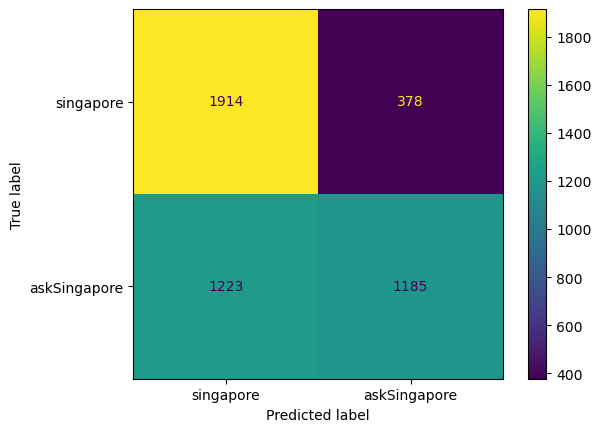

In [269]:
# Plot confusion matrix
y_preds = tvec_knn.predict(X_test)
cm = confusion_matrix(y_test, y_preds)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['singapore', 'askSingapore'])
display.plot();

## Model 7: CountVectorizer & Support Vector Machine (SVM)

In [211]:
# Try GridSearch with SVM

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# need to standardscale?

cvec_svm = Pipeline([
    ('cvec', CountVectorizer(stop_words=new_stopwords, max_features=4000)),
    ('ss', StandardScaler(with_mean=False)),
    ('svm', svm.SVC(C=0.91, kernel='rbf', degree=3, gamma=0.00003))
])


cvec_svm.get_params()

{'memory': None,
 'steps': [('cvec', CountVectorizer(max_features=4000,
                   stop_words=['singapor', 'free', 'hdb', 'www', 'top', 'care',
                               'small', 'gener', 'bto', 'world', 'ce', 'public',
                               'clean', 'woman', 'provid', 'support', 'unit',
                               'flat', 'scam', 'china', 'water', 'polic',
                               'increas', 'road', 'charg', 'system', 'claim',
                               'worker', 'detail', 'data', ...])),
  ('ss', StandardScaler(with_mean=False)),
  ('svm', SVC(C=0.91, gamma=3e-05))],
 'verbose': False,
 'cvec': CountVectorizer(max_features=4000,
                 stop_words=['singapor', 'free', 'hdb', 'www', 'top', 'care',
                             'small', 'gener', 'bto', 'world', 'ce', 'public',
                             'clean', 'woman', 'provid', 'support', 'unit',
                             'flat', 'scam', 'china', 'water', 'polic',
                     

In [212]:
cvec_svm.fit(X_train, y_train)


# Check Accuracy score 
print(f"Training score: {cvec_svm.score(X_train, y_train)}")
print(f"Testing score: {cvec_svm.score(X_test, y_test)}")

Training score: 0.7711732160590155
Testing score: 0.7440425531914894


In [214]:
# Get the number of features used in SVM model
cvec_svm[-1].n_features_in_

4000

## Model 8: TF-IDF Vectorizer & Support Vector Machine (SVM)

In [193]:
# Try GridSearch with SVM

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

tvec_svm = Pipeline([
    ('tvec', TfidfVectorizer(stop_words=new_stopwords, max_features=4000)),
    ('svm', svm.SVC(C=0.21, kernel='linear', degree=3, gamma='scale'))
])


tvec_svm.get_params()

{'memory': None,
 'steps': [('tvec', TfidfVectorizer(max_features=4000,
                   stop_words=['singapor', 'free', 'hdb', 'www', 'top', 'care',
                               'small', 'gener', 'bto', 'world', 'ce', 'public',
                               'clean', 'woman', 'provid', 'support', 'unit',
                               'flat', 'scam', 'china', 'water', 'polic',
                               'increas', 'road', 'charg', 'system', 'claim',
                               'worker', 'detail', 'data', ...])),
  ('svm', SVC(C=0.21, kernel='linear'))],
 'verbose': False,
 'tvec': TfidfVectorizer(max_features=4000,
                 stop_words=['singapor', 'free', 'hdb', 'www', 'top', 'care',
                             'small', 'gener', 'bto', 'world', 'ce', 'public',
                             'clean', 'woman', 'provid', 'support', 'unit',
                             'flat', 'scam', 'china', 'water', 'polic',
                             'increas', 'road', 'charg', 'sy

In [194]:
tvec_svm.fit(X_train, y_train)

# Check Accuracy score 
print(f"Training score: {tvec_svm.score(X_train, y_train)}")
print(f"Testing score: {tvec_svm.score(X_test, y_test)}")

Training score: 0.812526599517662
Testing score: 0.7702127659574468


In [195]:
# Get the number of features used in SVM model
tvec_svm[-1].n_features_in_

4000

## Model 9: CountVectorizer & RandomForestClassifier

In [15]:
# Try GridSearch with RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words=new_stopwords)),   # the presence of these new_stopwords do not influence accuracy result at all, so they are indeed noise!
    ('rf', RandomForestClassifier(random_state=42))
])


pipe.get_params()

{'memory': None,
 'steps': [('cvec',
   CountVectorizer(stop_words=['singapor', 'free', 'hdb', 'www', 'top', 'care',
                               'small', 'gener', 'bto', 'world', 'ce', 'public',
                               'clean', 'woman', 'provid', 'support', 'unit',
                               'flat', 'scam', 'china', 'water', 'polic',
                               'increas', 'road', 'charg', 'system', 'claim',
                               'worker', 'detail', 'data', ...])),
  ('rf', RandomForestClassifier(random_state=42))],
 'verbose': False,
 'cvec': CountVectorizer(stop_words=['singapor', 'free', 'hdb', 'www', 'top', 'care',
                             'small', 'gener', 'bto', 'world', 'ce', 'public',
                             'clean', 'woman', 'provid', 'support', 'unit',
                             'flat', 'scam', 'china', 'water', 'polic',
                             'increas', 'road', 'charg', 'system', 'claim',
                             'worker', 'detai

In [128]:
pipe_rf_params = [{
    'cvec__max_features': [50, 100],
    'cvec__ngram_range': [(1,1), (1,3)],
    'rf__n_estimators': [300],
    'rf__max_depth': [15]
}]

In [129]:
# Instantiate GridSearchCV
cvec_rf = GridSearchCV(pipe,
                      pipe_rf_params,
                      cv=5)

In [130]:
# Fit and score best model
cvec_rf.fit(X_train, y_train)


# Check Accuracy score 
print(f"Training score: {cvec_rf.score(X_train, y_train)}")
print(f"Testing score: {cvec_rf.score(X_test, y_test)}")

Training score: 0.7965154940816598
Testing score: 0.763563829787234


In [131]:
cvec_rf.best_params_

{'cvec__max_features': 100,
 'cvec__ngram_range': (1, 1),
 'rf__max_depth': 15,
 'rf__n_estimators': 300}

## Model 10: TF-IDF Vectorizer & RandomForestClassifier

In [6]:
# Try GridSearch with RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

pipe = Pipeline([
    ('tvec', TfidfVectorizer(stop_words=new_stopwords)),   # the presence of these new_stopwords do not influence accuracy result at all, so they are indeed noise!
    ('rf', RandomForestClassifier(random_state=42))
])


pipe.get_params()

{'memory': None,
 'steps': [('tvec',
   TfidfVectorizer(stop_words=['singapor', 'free', 'hdb', 'www', 'top', 'care',
                               'small', 'gener', 'bto', 'world', 'ce', 'public',
                               'clean', 'woman', 'provid', 'support', 'unit',
                               'flat', 'scam', 'china', 'water', 'polic',
                               'increas', 'road', 'charg', 'system', 'claim',
                               'worker', 'detail', 'data', ...])),
  ('rf', RandomForestClassifier(random_state=42))],
 'verbose': False,
 'tvec': TfidfVectorizer(stop_words=['singapor', 'free', 'hdb', 'www', 'top', 'care',
                             'small', 'gener', 'bto', 'world', 'ce', 'public',
                             'clean', 'woman', 'provid', 'support', 'unit',
                             'flat', 'scam', 'china', 'water', 'polic',
                             'increas', 'road', 'charg', 'system', 'claim',
                             'worker', 'detai

In [17]:
pipe_rf_params = [{
    'tvec__max_features': [50, 100],
    'tvec__ngram_range': [(1,1),(1,2),(1,3)],
    'rf__n_estimators': [300],
    'rf__max_depth': [15]
}]

In [18]:
# Instantiate GridSearchCV
tvec_rf = GridSearchCV(pipe,
                      pipe_rf_params,
                      cv=5)

In [19]:
# Fit and score best model
tvec_rf.fit(X_train, y_train)


# Check Accuracy score 
print(f"Training score: {tvec_rf.score(X_train, y_train)}")
print(f"Testing score: {tvec_rf.score(X_test, y_test)}")

Training score: 0.8079869485033339
Testing score: 0.7685106382978724


In [20]:
tvec_rf.best_params_

{'rf__max_depth': 15,
 'rf__n_estimators': 300,
 'tvec__max_features': 100,
 'tvec__ngram_range': (1, 1)}

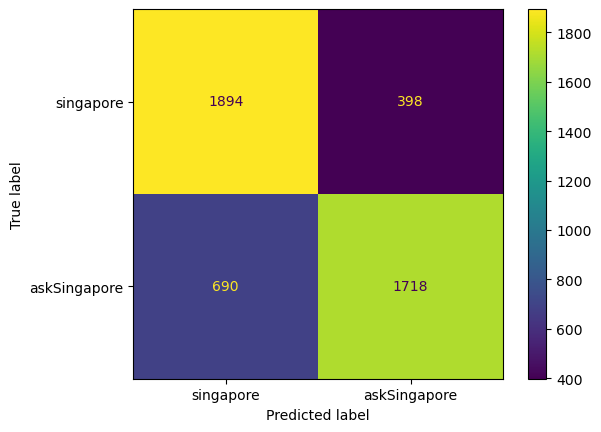

In [41]:
# Plot confusion matrix
y_preds = tvec_rf.predict(X_test)
cm = confusion_matrix(y_test, y_preds)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['singapore', 'askSingapore'])
display.plot();

In [22]:
print("Training Accuracy: ", tvec_rf.score(X_train, y_train))
print("Accuracy: ", accuracy_score(y_test, y_preds))
print("Precision: ", precision_score(y_test, y_preds))
print("Sensitivity: ", recall_score(y_test, y_preds))
print("F1 score: ", f1_score(y_test, y_preds))

Training Accuracy:  0.8079869485033339
Accuracy:  0.7685106382978724
Precision:  0.8119092627599244
Sensitivity:  0.7134551495016611
F1 score:  0.7595048629531388


_The model has high precision score of 81% which means that it is adept at predicting posts from r/askSingapore vs 73% correct predictions when it is predicting for r/Singapore._

In [23]:
# Get a ranking of the most important token features

feature_scores = tvec_rf.best_estimator_[-1].feature_importances_
feature_names = tvec_rf.best_estimator_[0].get_feature_names_out()
feature_importances = pd.DataFrame(list(zip(feature_names, feature_scores)), columns=['feature_name', 'feature_score'])
feature_importances.sort_values(by='feature_score', ascending=False).head(50)

,feature_name,feature_score
40,like,0.087554
84,thank,0.068509
98,would,0.062613
2,anyon,0.061910
38,know,0.048887
32,hi,0.042926
25,get,0.042517
43,look,0.037272
27,go,0.037141
97,work,0.032014


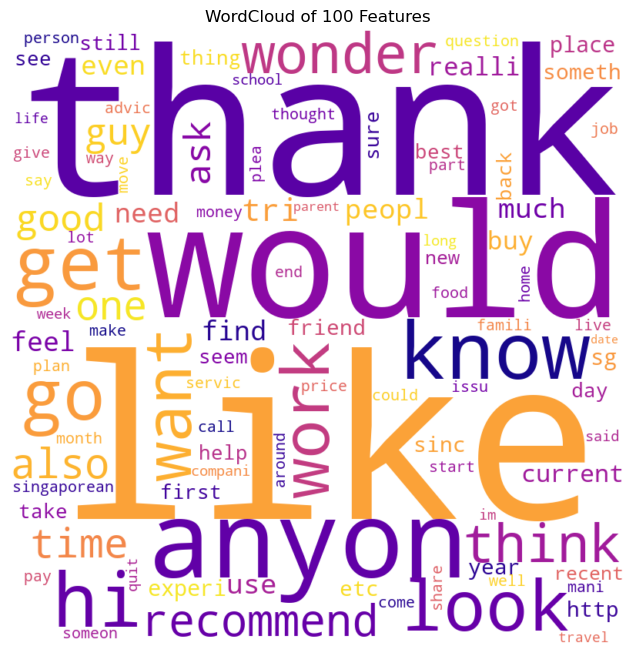

In [39]:
# Generate wordcloud for the 100 features sized according to their feature importances

word_weights = {}

for f in feature_importances['feature_name']:
    score=feature_importances.loc[feature_importances['feature_name']==f, 'feature_score'].item()
    word_weights[f]=score
    
wordcloud = WordCloud(width=800, height=800, background_color='white', colormap='plasma')
wordcloud.generate_from_frequencies(word_weights)

# Plot the word cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud of 100 Features')
plt.show()

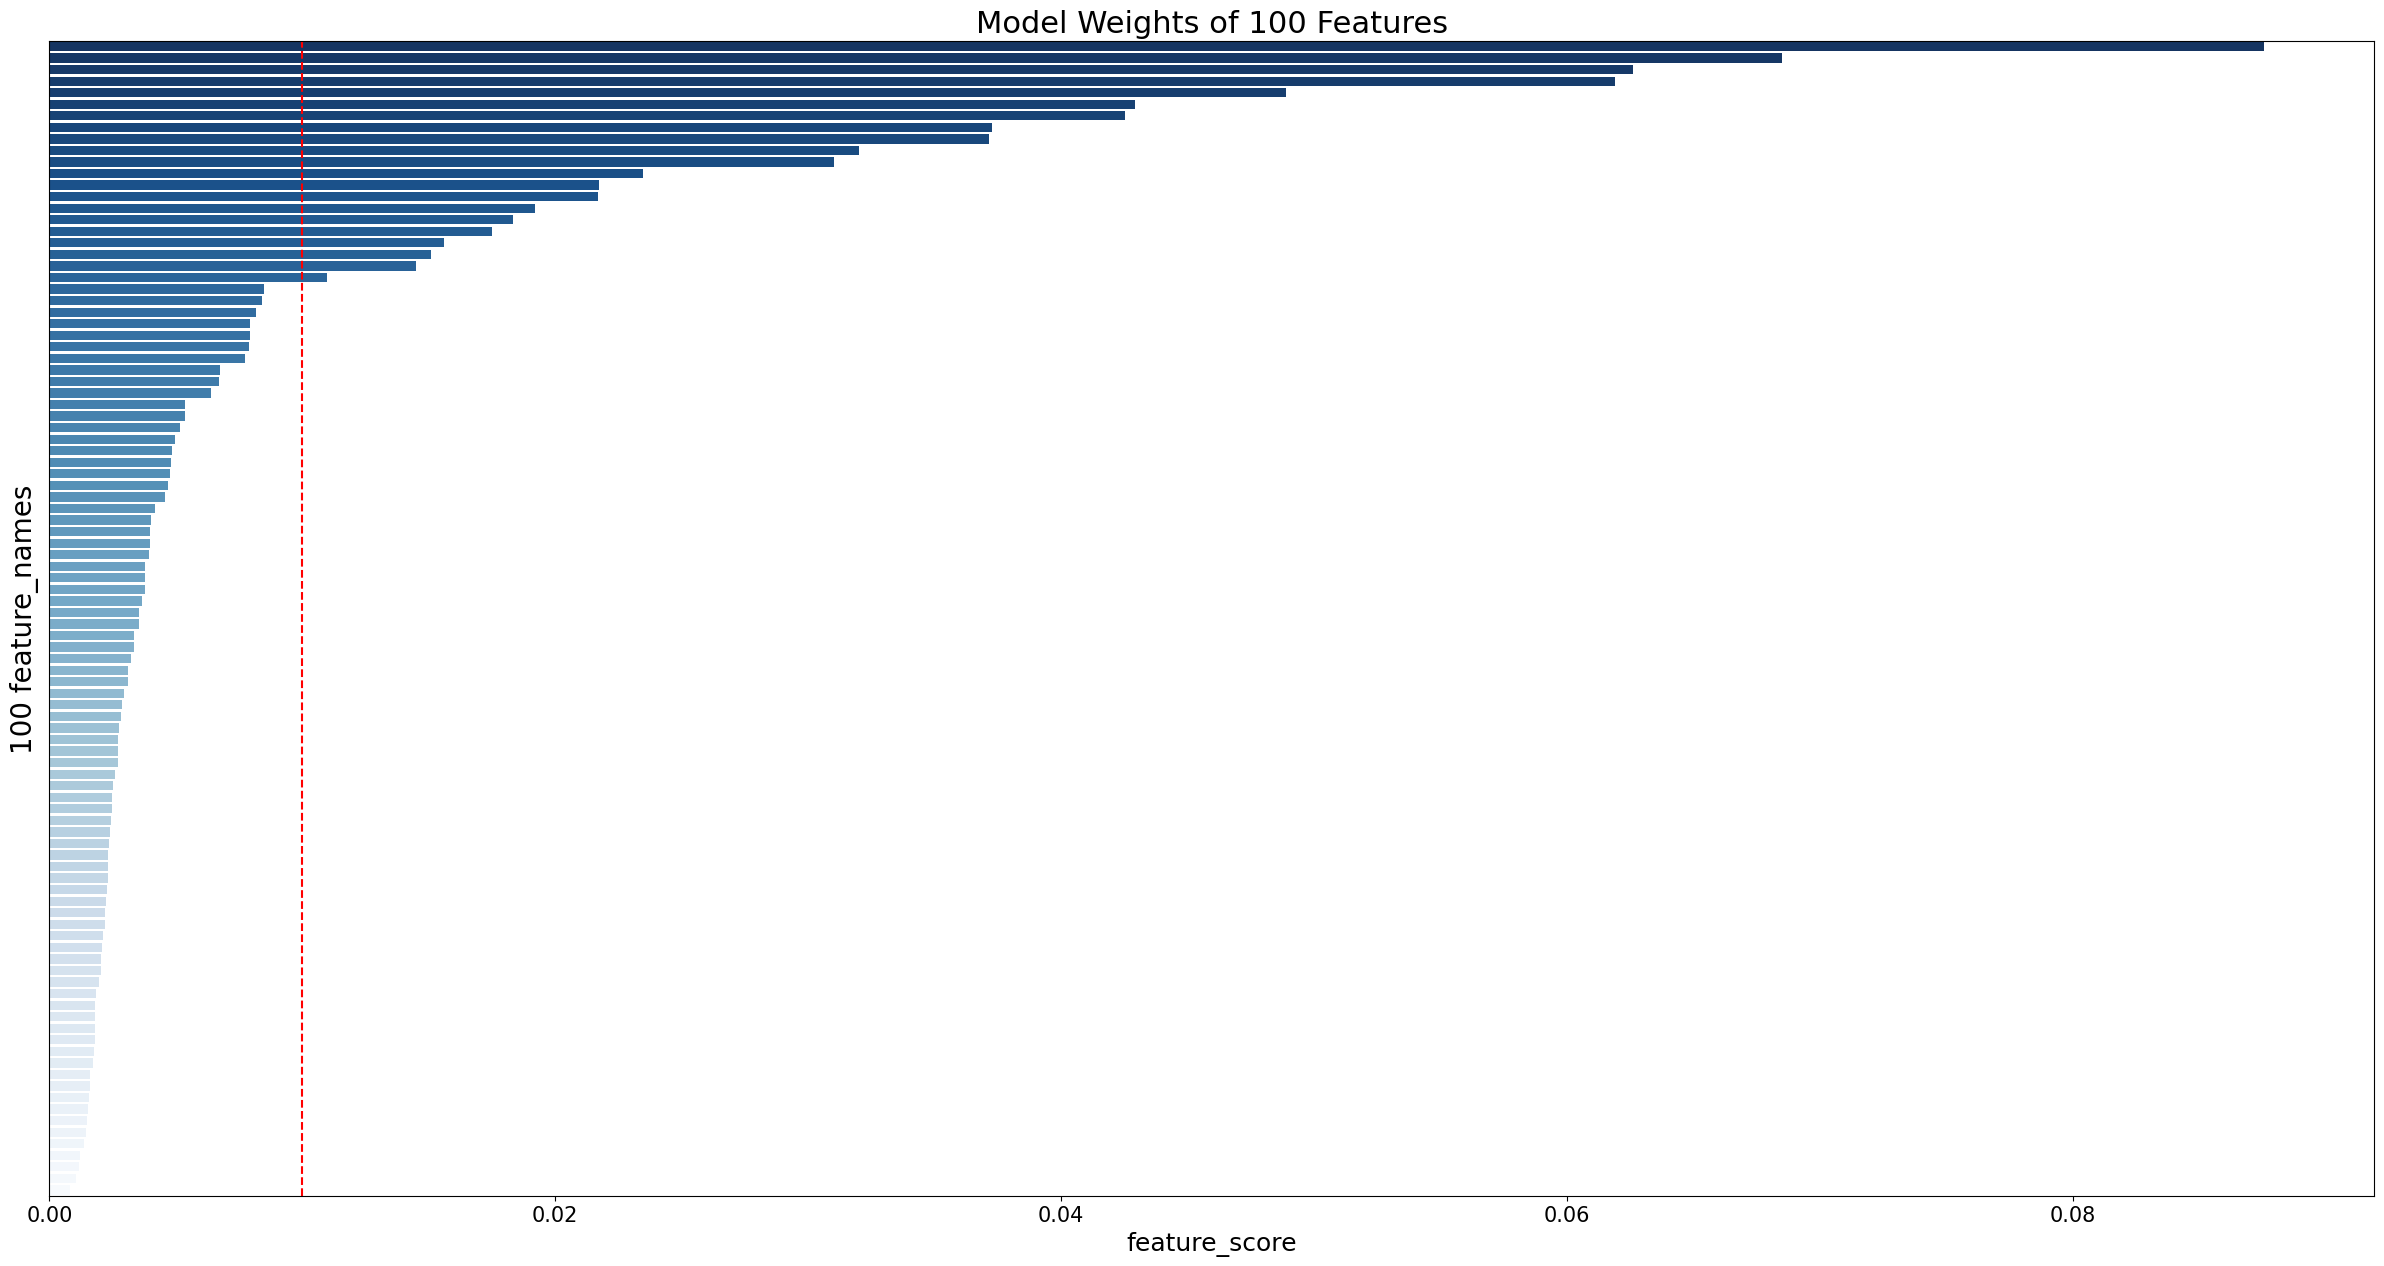

In [37]:
# Plot a chart displaying the 100 feature weights 

data = feature_importances.sort_values(by='feature_score', ascending=False)

plt.figure(figsize=(30,15))
ax = sns.barplot(x='feature_score', y='feature_name', data=data, orient='h', palette='Blues_r')
ax.set_yticks([])
plt.xlabel('feature_score', fontsize=18)
plt.ylabel('100 feature_names', fontsize=20)
plt.xticks(fontsize=15)
plt.title('Model Weights of 100 Features', fontsize=22)
ax.axvline(x=0.01, color='r', linestyle='--');

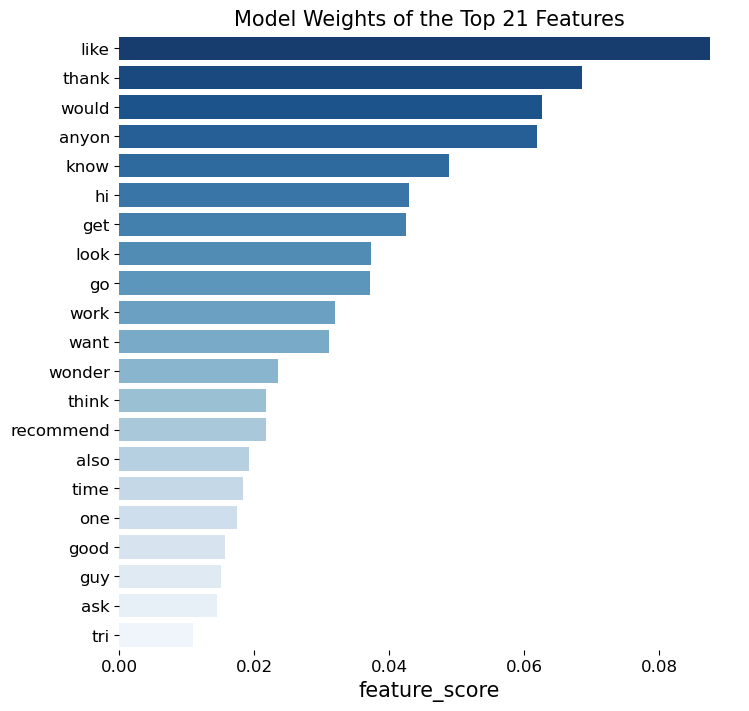

In [38]:
# Plot a chart displaying the Top 21 feature weights 

data = feature_importances.sort_values(by='feature_score', ascending=False)[:21]

plt.figure(figsize=(8,8))
ax = sns.barplot(x='feature_score', y='feature_name', data=data, orient='h', palette='Blues_r')
plt.xlabel('feature_score', fontsize=15)
plt.ylabel('')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Model Weights of the Top 21 Features', fontsize=15);

# Remove the plot border
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

In [27]:
# Summing the total weightings of features with scores > 1%
sum(feature_importances[feature_importances['feature_score']>0.01]['feature_score'])

0.7304852515322624

_Out of these 100 token features, the top 21 tokens contributed ~73% of accuracy weightings in the classification model. Given that the top 100 features accounted for ~80% of the model's accuracy, we can infer that ~58% of the model's accuracy can be attributable to just the top 22 features alone._    

In [28]:
# Get sentiment score of each of the top 100 token features used in the model

sia = SentimentIntensityAnalyzer()
dicts = []

for word in feature_names:
    scores = sia.polarity_scores(word)
    scores['word'] = word
    dicts.append(scores)
    
# Create dataframe with the dicts
features_sentiment = pd.DataFrame(dicts)
positive_tokens = features_sentiment[features_sentiment['compound']>0.0].shape[0]
negative_tokens = features_sentiment[features_sentiment['compound']<0.0].shape[0]
neutral_tokens = features_sentiment[features_sentiment['compound']==0.0].shape[0]
print(f'Number of positive tokens: {positive_tokens}')
print(f'Number of negative tokens: {negative_tokens}')
print(f'Number of neutral tokens: {neutral_tokens}')

Number of positive tokens: 11
Number of negative tokens: 1
Number of neutral tokens: 88


_From "EDA on Title+Selftext", we know that r\askSingapore has a significantly more positive sentiment that r\Singapore. But since ~90% of the 100 tokens appeared to be neutral, we are unable to show a significantly disproportionate number of positive tokens that have been used by our model to differentiate between the two classes. One reason could be because both classes are generally positive to begin with thus diluting the informational value of positive-sentiment words_ 

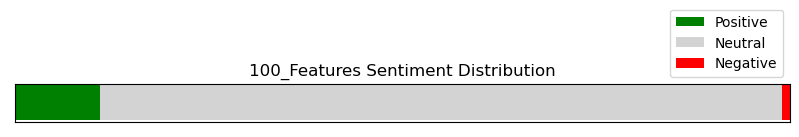

In [29]:
# Plot the sentiment distribution of the 100 features

total_tokens = positive_tokens+negative_tokens+neutral_tokens

sentiment_dict = {'positive':(positive_tokens/total_tokens),
                'neutral':(neutral_tokens/total_tokens),
                'negative':(negative_tokens/total_tokens)}



data = sentiment_dict
fig, ax = plt.subplots(figsize=(10,0.5))

# create horizontal bar plot
ax.barh(0, data['positive'], color='g')
ax.barh(0, data['neutral'], left=data['positive'], color='lightgray')
ax.barh(0, data['negative'], left=data['positive']+data['neutral'], color='r')

# set x axis limits to percentage values
ax.set_xlim([0, 1])
ax.set_xticks([])

# set y axis label
ax.set_yticks([])
ax.set_yticklabels([])

# set legend
ax.legend(['Positive', 'Neutral', 'Negative'], loc='lower right',  bbox_to_anchor=(1.0, 1.0))

# set plot title
ax.set_title('100_Features Sentiment Distribution')

# display plot
plt.show()

In [30]:
# Get sentiment score of each of the top 21 token features used in the model

top_21 = feature_importances.sort_values(by='feature_score', ascending=False).head(21)['feature_name']

sia = SentimentIntensityAnalyzer()
dicts = []

for word in top_21:
    scores = sia.polarity_scores(word)
    scores['word'] = word
    dicts.append(scores)
    
# Create dataframe with the dicts
top_21_sentiment = pd.DataFrame(dicts)
positive_tokens = top_21_sentiment[top_21_sentiment['compound']>0.0].shape[0]
negative_tokens = top_21_sentiment[top_21_sentiment['compound']<0.0].shape[0]
neutral_tokens = top_21_sentiment[top_21_sentiment['compound']==0.0].shape[0]
print(f'Number of positive tokens: {positive_tokens}')
print(f'Number of negative tokens: {negative_tokens}')
print(f'Number of neutral tokens: {neutral_tokens}')

Number of positive tokens: 5
Number of negative tokens: 0
Number of neutral tokens: 16


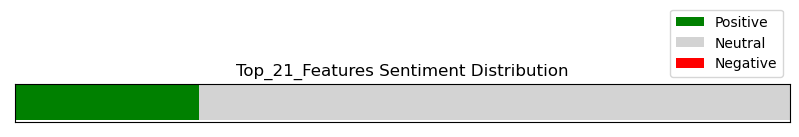

In [31]:
# Plot the sentiment distribution of the top 21 features

total_tokens = positive_tokens+negative_tokens+neutral_tokens

sentiment_dict = {'positive':(positive_tokens/total_tokens),
                'neutral':(neutral_tokens/total_tokens),
                'negative':(negative_tokens/total_tokens)}



data = sentiment_dict
fig, ax = plt.subplots(figsize=(10,0.5))

# create horizontal bar plot
ax.barh(0, data['positive'], color='g')
ax.barh(0, data['neutral'], left=data['positive'], color='lightgray')
ax.barh(0, data['negative'], left=data['positive']+data['neutral'], color='r')

# set x axis limits to percentage values
ax.set_xlim([0, 1])
ax.set_xticks([])

# set y axis label
ax.set_yticks([])
ax.set_yticklabels([])

# set legend
ax.legend(['Positive', 'Neutral', 'Negative'], loc='lower right',  bbox_to_anchor=(1.0, 1.0))

# set plot title
ax.set_title('Top_21_Features Sentiment Distribution')

# display plot
plt.show()

_And among the top 21 tokens, 5 of them are positive words. The remaining 7 positive words are found in the remaining 79 tokens. Such a concentration of positive words in the heavily-weighted top_21 features in the model suggest that our model was indeed successful in overweighting the right positive words in order to differentiate between the two classes._

## Conclusions and Recommendations

* Use TF-IDF Vectorizer + RandomForestClassifier

**Highly Simple**: Just 100 features only  
**Highly Accurate**: Scored ~80% both in-sample and out-sample  
**Highly Relevant**: Top 21 features contribute ~60% to the model’s accuracy  
**Not Highly Perfect!**: Slightly higher tendency to predict False Negatives due to overlap
